In [1]:
from heapq import nlargest

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utilities import load_graph_from_files, get_communities, load_concept_counts
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Miniconda3\envs\TwitterCovid19\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# define your region
REGION = 'netherlands'

In [3]:
# load graph (and nodes, for relabeling)
g, nodes_df = load_graph_from_files(region=REGION)

In [4]:
# load partitions and communities
partitions, _communities = get_communities(g)

# wrap for nicer usage
communities =  {key: {'nodes' : value} for key, value in _communities.items()}

Amount of communities larger than the mean (18.745745745745747): 59


[(0, 3655.695753744778)]

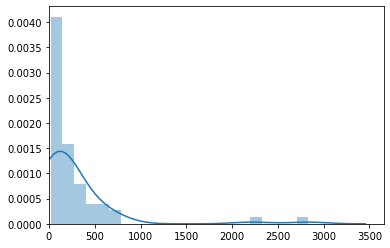

In [5]:
# get sizes for every community
all_lens = [len(c['nodes']) for _, c in communities.items()]

# get communities larger than the mean
lens_larger_than_mean = [x for x in all_lens if x > np.mean(all_lens)]
print('Amount of communities larger than the mean ({}): {}'.format(np.mean(all_lens), len(lens_larger_than_mean)))

# plot distribution
sns.distplot(lens_larger_than_mean).set(xlim=0)

In [6]:
# only includes communities with above average size
top_communities = {}

# for each community
for key, community in communities.items():
    # if its size is above average
    if len(community['nodes']) > np.mean(all_lens):
        top_communities[key] = community

In [7]:
# for each community
for key, community in top_communities.items():
    
    # create copy of graph
    sub_g = nx.Graph(g)
    
    # remove all nodes that do not belong to community
    sub_g.remove_nodes_from([node for node in g.nodes if node not in community['nodes']])
    
    # cache graph
    community['graph'] = sub_g
    
    # order nodes by degree
    degree_nodes = sorted(sub_g.degree, key=lambda x: x[1], reverse=True)
    
    # community named after node with highest degree
    community['name'] = degree_nodes[0][0]

In [8]:
# for each community
for key, community in top_communities.items():
    # load concepts (with counts) for all corresponding tweets
    community['concepts'] =  load_concept_counts(where="(tweet_body->'user'->>'id_str')::float IN ({})".format(','.join(str(node) for node in community['nodes'])))

In [9]:
# init empty dict of concepts
overall_concept_counts = {}

# run through all communities
for key, community in top_communities.items():
    # increment concept counter if concept found in this community
    for concept in community['concepts']['concept']:
        if concept not in overall_concept_counts:
            overall_concept_counts[concept] = 0
        else:
            overall_concept_counts[concept] = overall_concept_counts[concept] + 1
            

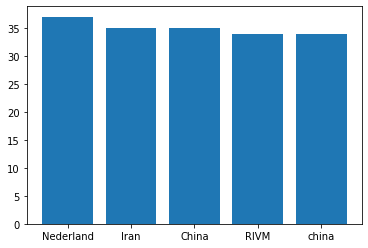

In [12]:
# get the top 5 concepts
top_overall_concept_counts_keys = nlargest(5, overall_concept_counts, key=overall_concept_counts.get)
top_overall_concept_counts = {key : overall_concept_counts[key] for key in top_overall_concept_counts_keys}

# plot them as a bar chart
plt.bar(range(len(top_overall_concept_counts)), list(top_overall_concept_counts.values()), align='center')
plt.xticks(range(len(top_overall_concept_counts)), list(top_overall_concept_counts.keys()))
plt.show()